In [1]:
#importing Kagglehub module to process the dataset
import kagglehub

In [2]:
#working with LI-Medium data, downloading files
kagglehub.dataset_download("ealtman2019/ibm-transactions-for-anti-money-laundering-aml", path="LI-Medium_Trans.csv")
kagglehub.dataset_download("ealtman2019/ibm-transactions-for-anti-money-laundering-aml", path="LI-Medium_accounts.csv")
kagglehub.dataset_download("ealtman2019/ibm-transactions-for-anti-money-laundering-aml", path="LI-Medium_Patterns.txt")



100%|██████████| 2.77G/2.77G [00:46<00:00, 63.7MB/s]


100%|██████████| 135M/135M [00:02<00:00, 56.6MB/s] 


100%|██████████| 382k/382k [00:00<00:00, 1.28MB/s]


'/home/d2molina/.cache/kagglehub/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml/versions/8/LI-Medium_Patterns.txt'

In [1]:
import pandas as pd

BASE = "/home/d2molina/.cache/kagglehub/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml/versions/8"

trans = pd.read_csv(f"{BASE}/LI-Medium_Trans.csv", nrows=1_000_000)
trans.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:15,20,800104D70,20,800104D70,8095.07,US Dollar,8095.07,US Dollar,Reinvestment,0
1,2022/09/01 00:18,3196,800107150,3196,800107150,7739.29,US Dollar,7739.29,US Dollar,Reinvestment,0
2,2022/09/01 00:23,1208,80010E430,1208,80010E430,2654.22,US Dollar,2654.22,US Dollar,Reinvestment,0
3,2022/09/01 00:19,3203,80010EA80,3203,80010EA80,13284.41,US Dollar,13284.41,US Dollar,Reinvestment,0
4,2022/09/01 00:27,20,800104D20,20,800104D20,9.72,US Dollar,9.72,US Dollar,Reinvestment,0


In [21]:
laund_props = trans['Is Laundering'].value_counts(normalize=True)
laund_props
#extremely large class imbalance, even in the sample --> improve precision/recall measures w/in minority class

Is Laundering
0    0.999929
1    0.000071
Name: proportion, dtype: float64

<Axes: title={'center': 'Class Imbalance: Laundering vs. Non-Laundering'}, xlabel='Is Laundering'>

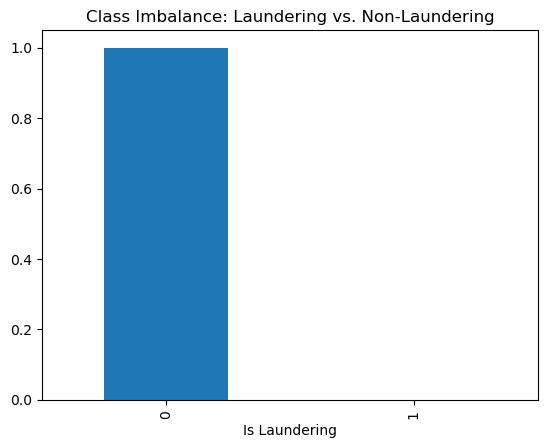

In [23]:
laund_props.plot(kind='bar', title='Class Imbalance: Laundering vs. Non-Laundering')

In [16]:
pd.options.display.float_format = '{:,.0f}'.format
trans.describe()

,From Bank,To Bank,Amount Received,Amount Paid,Is Laundering
count,"1,000,000","1,000,000","1,000,000","1,000,000","1,000,000"
mean,"272,937","284,005","25,805,076","17,071,960",0
std,"562,887","555,114","4,227,445,918","3,035,502,905",0
min,0,0,0,0,0
25%,"21,517","25,817",23,23,0
50%,"119,717","126,173","2,676","2,684",0
75%,"234,197","234,776","44,068","44,095",0
max,"3,219,754","3,219,754","1,530,956,545,569","1,530,956,545,569",1


In [13]:
trans.groupby('Is Laundering')[['Amount Received', 'Amount Paid']].describe()

Amount Received                                            \
                        count       mean           std min   25%    50%   
Is Laundering                                                             
0                     999,929 25,801,390 4,227,594,564   0    23  2,675   
1                          71 77,709,174   413,104,795 131 5,070 13,667   

                                        Amount Paid                           \
                  75%               max       count       mean           std   
Is Laundering                                                                  
0              44,065 1,530,956,545,569     999,929 17,067,654 3,035,608,661   
1             251,300     2,520,216,483          71 77,709,174   413,104,795   

                                                          
              min   25%    50%     75%               max  
Is Laundering                                             
0               0    23  2,683  44,091 1,530,956,545,569  
1             131 5,070 13,667 251,300     2,520,216,483

In [17]:
pd.reset_option('display.float_format')
trans['Payment Format'].value_counts(normalize=True)

Payment Format
Reinvestment    0.726406
Cheque          0.099496
Credit Card     0.090884
ACH             0.045296
Cash            0.026198
Wire            0.011521
Bitcoin         0.000199
Name: proportion, dtype: float64

In [20]:
trans.groupby('Payment Format')['Is Laundering'].mean().sort_values(ascending=False)

Payment Format
ACH             0.000729
Cash            0.000344
Cheque          0.000231
Credit Card     0.000066
Bitcoin         0.000000
Reinvestment    0.000000
Wire            0.000000
Name: Is Laundering, dtype: float64

<Axes: xlabel='log_amount_paid', ylabel='Density'>

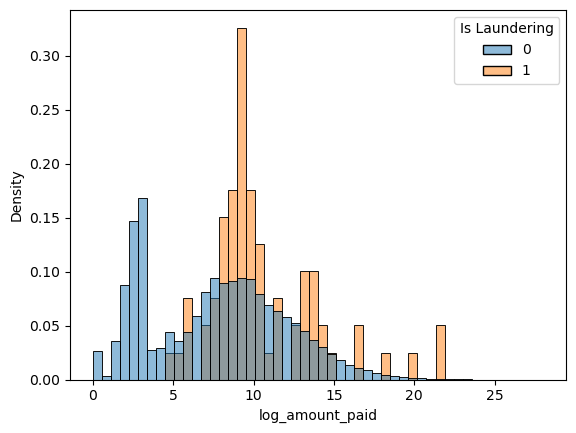

In [24]:
import seaborn as sns
import numpy as np

trans['log_amount_paid'] = np.log1p(trans['Amount Paid'])
sns.histplot(data=trans, x='log_amount_paid', hue='Is Laundering', bins=50, stat='density', common_norm=False)

<Axes: title={'center': 'Laundering Rate by Payment Format'}, xlabel='Payment Format'>

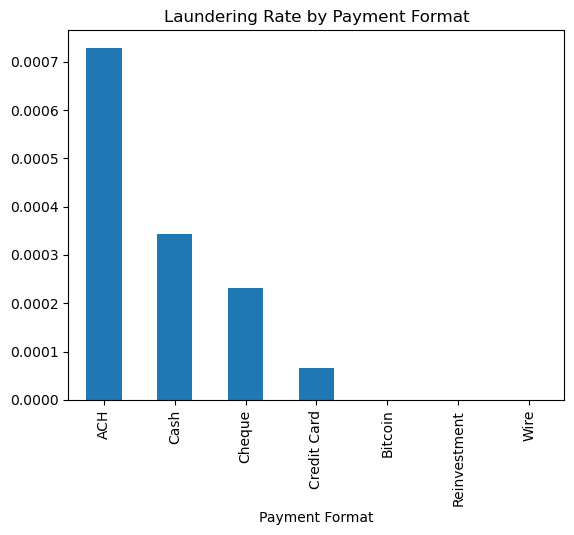

In [25]:
rate_by_form = trans.groupby('Payment Format')['Is Laundering'].mean().sort_values(ascending=False)
rate_by_form.plot(kind='bar', title='Laundering Rate by Payment Format')

<Axes: title={'center': 'Daily Laundering Rate Over Time'}, xlabel='Timestamp'>

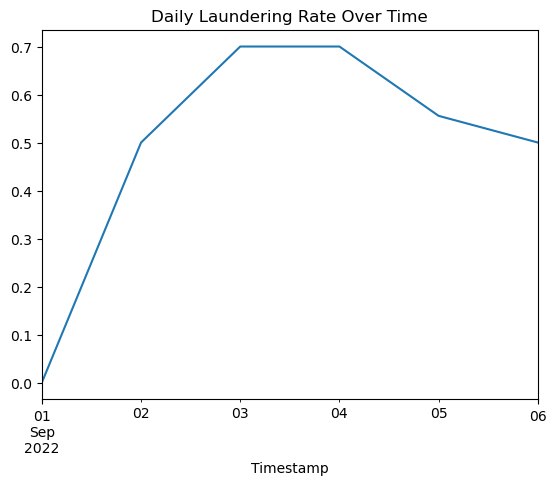

In [26]:
trans['Timestamp'] = pd.to_datetime(trans['Timestamp'])

daily_rate = (trans.set_index('Timestamp').resample('D')['Is Laundering'].mean())
daily_rate.plot(title='Daily Laundering Rate Over Time')